In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


캡차 인식
```
이미지 안의 다양한 텍스트를 인식
CRNN + GRU
```

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fournierp/captcha-version-2-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/captcha-version-2-images


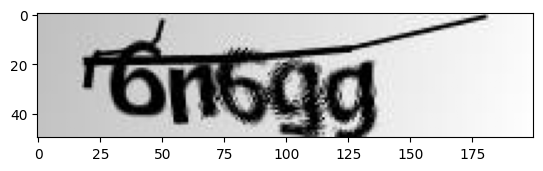

In [ ]:
import matplotlib.pyplot as plt
from glob import glob
file_lists = glob(path + '/**/*.*', recursive=True)
file_lists[:3]
plt.imshow(plt.imread(file_lists[0]))

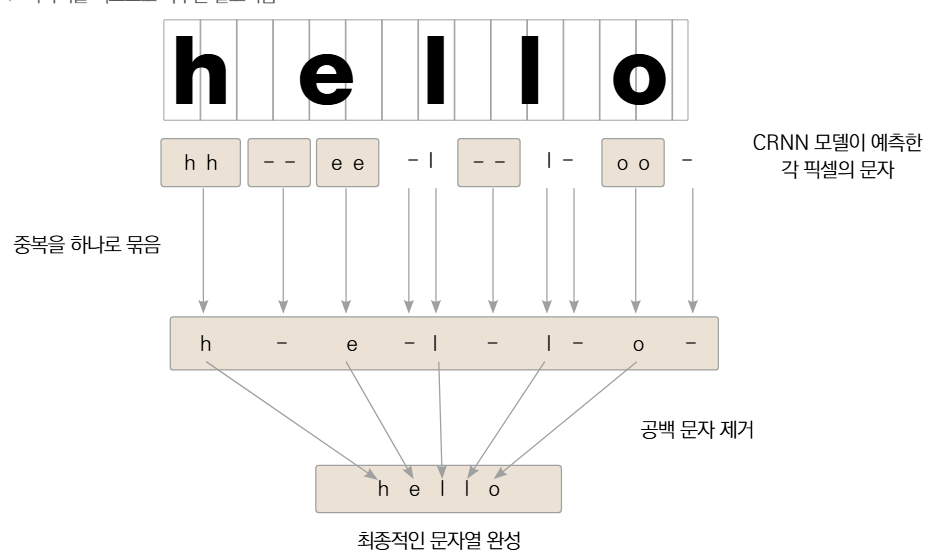

CRNN
```
CNN의 특성맵을 RNN의 입력으로 처리
RNN 보다 성능이 더 우수한 GRU를 이용
CNN 추출된 특징은 W개 픽셀, H개 픽셀 --> RNN 에서 입력할수 있도록
변경해 줘야 함
글자를 표현하지 않는 공백은 -표시, 중보제거하면 연속된 문자
CTC 손실
  CRNN  : 같은 문자를 여러방식으로 표현, CTC 가능한 모든 표현 방식을 고려해서 손실을 계산

```
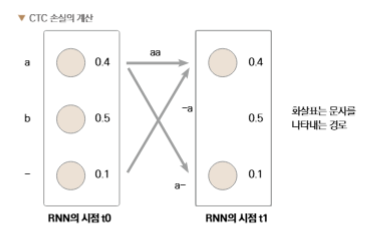

CTC : 하나의 정답을 표현하는 방법이 여러가지 존재할때 모든 경우의 수에 대한 확률을 더하는 함수

학습용 데이터셋
  - 정답은 파일명
  - 정답에 등장하는 모든 문자들로 부터 단어사전 BOW

In [ ]:
import numpy as np
from torch.utils.data.dataset import Dataset
# 말뭉치를 받아서 단어사전
def get_BOW(corpus):
  BOW = {'<pad>' : 0}  # 공백문자를 0
  # corpus의 문자를 이용해서 BOW에 인덱싱  - 정수인덱싱  고유번호 부여
  for w in corpus:
    if w not in BOW:  # BOW.keys()
      BOW[w] = len(BOW)
  return BOW

In [ ]:
import string
from PIL import Image
import torch
class Capcha(Dataset):
  def __init__(self,path, train=True):
    # 소문자와숫자만 정답으로 사용
    corpus = string.ascii_lowercase+string.digits
    self.BOW= self.get_BOW(corpus)
    self.file_lists = glob(path)  # ~~~/*.png
    self.train=train
    # 8: 2
    split_num = int(len(self.file_lists)*0.8)
    self.trainset = self.file_lists[ : split_num]
    self.testset = self.file_lists[split_num : ]
  def __len__(self):
    if self.train:
      return len(self.trainset)
    else:
      return len(self.testset)
  def __getitem__(self, index):
    if self.train:
      # png - >RGB  Image.open(  ).convert('RGB')
      data = Image.open(self.trainset[index]).convert('RGB')  # 채널이 가장 마지막에
      data = torch.tensor(np.array(data),dtype=torch.float32)
      # 파이토치는 채널이 앞에 와야함
      data = data.permute(2,0,1)
      label = self.trainset[index].split('/')[-1].split('.')[0]
      # 정답을 (문자->숫자)  정수 인코딩
      label = self.get_seq(label)
      label = torch.tensor(label,dtype=torch.float32)
      return data, label
    else:
      # png - >RGB  Image.open(  ).convert('RGB')
      data = Image.open(self.testset[index]).convert('RGB')  # 채널이 가장 마지막에
      data = torch.tensor(np.array(data),dtype=torch.float32)
      # 파이토치는 채널이 앞에 와야함
      data = data.permute(2,0,1)
      label = self.testset[index].split('/')[-1].split('.')[0]
      # 정답을 (문자->숫자)  정수 인코딩
      label = self.get_seq(label)
      label = torch.tensor(label,dtype=torch.int32)
      return data, label
  def get_BOW(self, corpus):
    BOW = {'<pad>' : 0}  # 공백문자를 0
    # corpus의 문자를 이용해서 BOW에 인덱싱  - 정수인덱싱  고유번호 부여
    for w in corpus:
      if w not in BOW:  # BOW.keys()
        BOW[w] = len(BOW)
    return BOW
  # 문자를 숫자로표현 - 신경망 이해
  def get_seq(self, line):
    label = []
    for latter in line:
      label.append(self.BOW[latter])
    return label

최종적으로 RNN의 입력으로 들어가야 함으로 세로방향의 픽셀은 1개만 존재
 - 합성곱을 거칠수록 세로방향을 픽셀수를 줄여나간다
 - 세로방향의 픽셀이 1개여도 정보는 누적되기 떄문에
 - 커널의 스트라이드를 조정
 - 커널의 크기는 합성곱마다 다르다
 ```
  X - [ (합성곱-배치정규화 -랠루) - (합성곱-배치정규화) ] -랠루) - +(X) -->출력
 ```

BasicBlock
```
합성곱 x 2
배치정규화 x 2
렐루 x 1
```

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# 세로 픽셀을 줄이기 위해서 커널 크기는 3x5
class BasicBlock(nn.Module):
  def __init__ (self,in_channels, out_channels, kernel_size = (3,5), stride=(2,1)):
    super().__init__()
    # kernel size : 세로 가로
    # stride : 세로 가로
    # kernel_size=(3,5) 새로로 긴 형태
    # stride=(2,1) 세로는 2배(다운샘플링) 가로는 1배(크기유지) -> 높이가 절반으로 줄어듬
    self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size, stride)
    # 3,3 커널 사용
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=(3,3),padding=1)
    self.downsample = nn.Conv2d(in_channels,out_channels,kernel_size,stride)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
  def forward(self,x):
    x_ = x #스킵커낵션 대상
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.bn2(self.conv2(x))
    # 최종적으로 크기를 맞추기 위해서
    x_ = self.downsample(x_)
    x += x_
    x = self.relu(x)
    return x

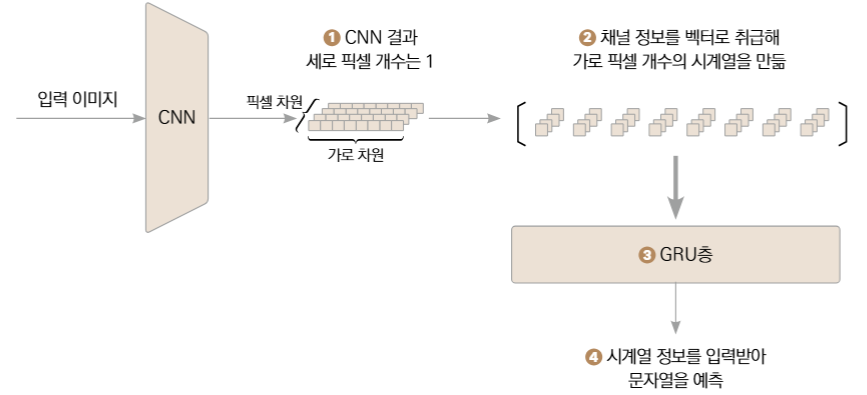

In [ ]:
capcha_data = Capcha(path = path+'/**/*.*')
data, label = next(iter(capcha_data))
print(data.shape ,label)
b1 = BasicBlock(3,64)
b1_output = b1(data.unsqueeze(0))
print(b1_output.shape)

b2 = BasicBlock(64,64)
b2_output = b2(b1_output)
print(b2_output.shape)

b3 = BasicBlock(64,64)
b3_output = b3(b2_output)
print(b3_output.shape)

b4 = BasicBlock(64,64)
b4_output = b4(b3_output)
print(b4_output.shape)

c = nn.Conv2d(64,64,kernel_size=(2,5))
c_output = c(b4_output)
print(c_output.shape)

torch.Size([3, 50, 200]) [33, 14, 33, 7, 7]
torch.Size([1, 64, 24, 196])
torch.Size([1, 64, 11, 192])
torch.Size([1, 64, 5, 188])
torch.Size([1, 64, 2, 184])
torch.Size([1, 64, 1, 180])


In [ ]:
class CRNN(nn.Module):
  def __init__(self,output_size):
    super().__init__()
    # cnn 층 정의  (none, 3, 50, 200)
    self.block = nn.Sequential(
      BasicBlock(3,64), # none, 64, 24, 196
      BasicBlock(64,64), # none, 64, 11, 192
      BasicBlock(64,64), # none, 64, 5, 188
      BasicBlock(64,64), # none, 64, 2, 184
      # 아래와 같은 convolution은 문자단위의 시퀀스추출 기본형태
      # none, 64, 1, 180
      # h:2 세로 방향의 정보를 한번에 압축, w:5 단어 또는 문자패턴을 뽑으려고
      nn.Conv2d(64,64,kernel_size=(2,5))
    )
    # GRU
    self.gru = nn.GRU(64,64,batch_first = False)  # (seq_len, batch, C)  (W,B,C)
    # 분류 MLP
    self.fc = nn.Sequential(
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,output_size)
    )
  def forward(self,x):
    x = self.block(x)  #1, 64, 1, 180( B, C, H, W) -> 1,64,180(B,C,W)(0,1,2)  permute(2,0,1)
    x = x.squeeze(2)
    x = x.permute(2,0,1)
    # 초기 은닉층(num_layer, batch_size, hidden_size)
    h0 = torch.zeros(1,x.size(1),64).to(device)
    x, _ = self.gru(x,h0)
    x = self.fc(x)
    # CTC 손실계산 로그 소프트 맥스
    x = F.log_softmax(x, dim=-1)
    return x
# cnn 거치기전 이미지 (B,C H, W) (B, 3,50,200)
# 합성곱층을 전부 통과하면 (B, 64, 1, 180) -- GRU (180,B,64)
# MLP -> 각 픽셀이 어떤 문자에 속하는지 알수있음


학습

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = Capcha(path+'/**/*.png')
dataloader = DataLoader(dataset, batch_size=8)
model = CRNN(output_size = len(dataset.BOW)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
loss_fn = nn.CTCLoss()

for epoch in range(200):
  iterator = tqdm(dataloader)
  for data, label in iterator:
    data,label = data.to(device), label.to(device)
    predict = model(data)
    # CTC 손실 계산은 텐서의 모양까지 넣어줘야함
    # 시계열을 묶은 모양으로
    # predict.size(0) 시퀀스의 길이
    # [predict.size(0)]*8  동일한 길이를 가져야.... 배치가 8 ([T,T,T ...])
    predict_size = torch.IntTensor([predict.size(0)]*8).to(device)
    # 정답의 모양을 나타내는 변수
    target_size = torch.IntTensor([ len(txt) for txt in label]).to(device)
    # 손실 계산
    loss = loss_fn(predict, label, predict_size, target_size)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    iterator.set_description(f'epoch : {epoch+1}')
    iterator.set_postfix(loss = loss.item() / len(dataloader))

epoch : 200: 100%|██████████| 104/104 [00:08<00:00, 12.95it/s, loss=2.1e-7]


In [ ]:
torch.save(model.state_dict(),'/content/capcha.pth')

In [ ]:
# 모델 객체생성
# model.load_state_dict(torch.load('capcha.pth'.map_location = device))
testdataset = Capcha(path+'/**/*.png',train=False)
model.eval()
with torch.no_grad():
  data, label = next(iter(testdataset))
  data,label = data.to(device), label.to(device)
  print(data.shape)
  predict = model(data.unsqueeze(0)) # 1, 3, 50, 200 (0 1 2 3)
  print(predict.shape)
  _, predicted = torch.max(predict, dim=-1)
  predicted =  predicted.squeeze(1).cpu().numpy()
  # 연속된 동일한 문자 제거(중복제거)
  prev_char = None
  result = []
  for char in predicted:
    if char != prev_char and char != 0:
      result.append(char)
    prev_char = char
  print(result, label)

torch.Size([3, 50, 200])
torch.Size([180, 1, 37])
[np.int64(16), np.int64(7), np.int64(29), np.int64(16), np.int64(13)] tensor([16.,  7., 29., 16., 13.], device='cuda:0')


torch.Size([50, 200, 3])
torch.Size([200, 3, 50])


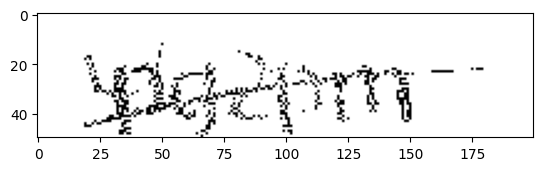

In [ ]:
import matplotlib.pyplot as plt
temp = data
print(data.shape)
data = data.permute(1,2,0)
print(data.shape)
temp = temp.cpu().numpy()
plt.imshow(temp)

In [ ]:
convert_bow = dict([(v,k) for k,v in dataset.BOW.items()])
''.join([convert_bow[num]for num in result])

'pg2pm'

GAN
```
진짜와 가짜를 구별 할 수 없을 정도로 정교한 가짜를 만드는 생성자를 학습하는 알고리즘
생성자
  가짜 데이터를 만들어냄
  노이즈 데이터(랜덤데이터)를 받아서 진짜 같은 이미지나 음성 텍스트등을 생성
편별자(감별자)
  생성자가 만든 가짜와 실제데이터를 비교해서 판단
```
```
데이터
  실제데이터
  생성자에 입력할 무작위 노이즈 데이터
가짜데이터 새엇ㅇ
  생성자는 노이즈 벡터를 받아서 가짜 데이터 생성
판별자 학습
  가짜데이터, 진짜데이터를 모두 입력 받아서 각 데이터가 진짜일 확률을 출력
  보통을 이진분류로 접근 실제데이터는 1, 가짜데이터는 0을 정답레이블로 생성
  손실함수 : 이진크로스엔트로피
생성자 학습
  판별자의 파라미터를 고정한 상태에서 생성자는 업데이트 됨
  판별자가 생성자가 생성한 데이터를 1이라고 잘못 분류하도록 생서자의 파리미터를 조정
  손실함수 : 이진 크로스 엔트로피
```

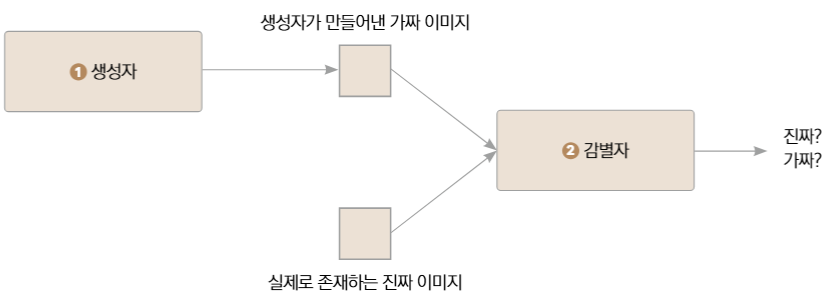